In [1]:
import os

from dotenv import load_dotenv

load_dotenv(os.path.join(".", ".env"), override=True)

%load_ext autoreload
%autoreload 2

## 컨텍스트 격리: 서브 에이전트
<img src="./assets/agent_header_subagent.png" width="800" style="display:block; margin-left:0;">
대화가 진행됨에 따라 에이전트 컨텍스트는 빠르게 확장될 수 있으며, 이는 여러 가지 장기적인 컨텍스트 관련 문제를 야기합니다. 주요 문제 중 하나는 컨텍스트 충돌 또는 혼란으로, 동일한 컨텍스트 창 내에서 혼합된 목표가 비최적의 성능으로 이어질 수 있습니다. [컨텍스트 격리](https://blog.langchain.com/context-engineering-for-agents/)는 작업을 [전문화된 서브 에이전트](https://www.anthropic.com/engineering/multi-agent-research-system)에 위임함으로써 효과적인 해결책을 제공합니다. 각 서브 에이전트는 자체 격리된 컨텍스트 창 내에서 작동합니다. 이 접근법은 컨텍스트 충돌, 혼란, 오염 및 희석을 방지하면서 집중적이고 전문화된 작업 실행을 가능하게 합니다.


### 서브 에이전트 위임
![./assets/subagents.png](./assets/subagents.png)
핵심 통찰은 특정 작업에 맞춤화된 서로 다른 도구 세트를 가진 서브 에이전트를 생성할 수 있다는 점입니다. 각 하위 에이전트는 `subagent_type`을 키로 하는 레지스트리 사전(dictionary)에 저장되며, 주 에이전트는 `task(description, subagent_type)` 도구 호출을 통해 작업을 위임할 수 있습니다. 하위 에이전트는 부모의 컨텍스트와 완전히 격리된 상태로 작동하며, 그 결과는 `ToolMessage`로 부모 에이전트에 반환되어 관심사의 명확한 분리를 유지합니다.

## 1단계: 하위 에이전트 생성

사용자가 하위 에이전트를 지정하는 방식을 정의해 보겠습니다
```python
from typing_extensions import TypedDict

class SubAgent(TypedDict):
    “”“특화된 하위 에이전트 구성.”“”

    name: str
    description: str
    prompt: str
    tools: NotRequired[list[str]]
```

이 객체들의 리스트를 사용해 접근 가능한 모든 서브 에이전트를 생성할 것입니다

```python
agents: list[SubAgent] = ...
subagents = {
    agent[‘name’]: create_react_agent(
        model=model,
        prompt=agent[‘prompt’],
        tools = get_tools(agent[‘tools’]),
        ...
    )
}
```

## 2단계: 서브 에이전트 사용 도구 생성

논리적으로는 다음과 같아야 합니다:

```python
def task(
    description: str  # 서브 에이전트가 수행할 작업
    subagent_type: str  # 사용할 서브 에이전트 유형
):
    # 서브 에이전트에 전달할 새 메시지 생성 - 설명만 포함
    # 서브 에이전트 호출
    # 서브 에이전트의 응답과 파일 시스템 변경 사항 모두로 상태 업데이트
```

전체적으로 다음과 같이 완성됩니다:

```python
@tool(description=TASK_DESCRIPTION_PREFIX.format(other_agents=other_agents_string))
def task(
    description: str,
    subagent_type: str,
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
):
    “”"작업 내용을 분리된 컨텍스트를 가진 전문 서브에이전트에게 위임합니다.

    이는 하위 에이전트를 위한 새 컨텍스트를 생성하며,
    여기에는 작업 설명만 포함되어 부모 에이전트의 대화 기록으로 인한 컨텍스트 오염을 방지합니다.
    “”"
    # 요청된 에이전트 유형이 존재하는지 검증
    if subagent_type not in agents:
        return f“오류: {subagent_type} 유형의 에이전트를 호출했습니다. 허용되는 유형은 {[f'`{k}`' for k in agents]} 뿐입니다.”

    # 요청된 서브 에이전트 가져오기
    sub_agent = agents[subagent_type]

    # 작업 설명만 포함된 격리된 컨텍스트 생성
    # 컨텍스트 격리의 핵심 - 부모 기록 없음
    state[“messages”] = [{“role”: ‘user’, “content”: description}]

    # 격리된 상태에서 서브 에이전트 실행
    result = sub_agent.invoke(state)

    # 명령 상태 업데이트를 통해 부모 에이전트에 결과 반환
    return Command(
        update={
            “files”: result.get(“files”, {}),  # 파일 변경 사항 병합
            “messages”: [
                # 하위 에이전트 결과가 부모 컨텍스트에서 ToolMessage로 변환
                ToolMessage(
                    result[“messages”][-1].content, tool_call_id=tool_call_id
                )
            ],
        }
    )

return task
```

In [2]:
%%writefile ./src/deep_agents_from_scratch/task_tool.py
"""하위 에이전트를 통한 컨텍스트 격리를 위한 작업 위임 도구.

이 모듈은 격리된 컨텍스트를 가진 하위 에이전트를 생성하고 관리하기 위한 핵심 인프라를 제공합니다. 
하위 에이전트는 특정 작업 설명만 포함된 깨끗한 컨텍스트 창으로 작동함으로써 컨텍스트 충돌을 방지합니다.
"""

from typing import Annotated, NotRequired
from typing_extensions import TypedDict

from langchain_core.messages import ToolMessage
from langchain_core.tools import BaseTool, InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState, create_react_agent
from langgraph.types import Command

from deep_agents_from_scratch.prompts import TASK_DESCRIPTION_PREFIX
from deep_agents_from_scratch.state import DeepAgentState


class SubAgent(TypedDict):
    """특화된 하위 에이전트용 구성."""

    name: str
    description: str
    prompt: str
    tools: NotRequired[list[str]]


def _create_task_tool(tools, subagents: list[SubAgent], model, state_schema):
    """서브 에이전트를 통해 컨텍스트 격리를 가능하게 하는 작업 위임 도구를 생성합니다.

    이 기능은 격리된 컨텍스트를 가진 특수화된 서브 에이전트를 생성하는 핵심 패턴을 구현하여
    복잡한 다단계 작업에서 컨텍스트 충돌과 혼란을 방지합니다.

    Args:
        tools: 서브 에이전트에 할당 가능한 사용 가능한 도구 목록
        subagents: 특수화된 서브 에이전트 구성 목록
        model: 모든 에이전트에 사용할 언어 모델
        state_schema: 상태 스키마 (일반적으로 DeepAgentState)

    Returns:
        특수화된 서브 에이전트에 작업을 위임할 수 있는 ‘작업’ 도구
    """
    # Create agent registry
    agents = {}

    # Build tool name mapping for selective tool assignment
    tools_by_name = {}
    for tool_ in tools:
        if not isinstance(tool_, BaseTool):
            tool_ = tool(tool_)
        tools_by_name[tool_.name] = tool_

    # Create specialized sub-agents based on configurations
    for _agent in subagents:
        if "tools" in _agent:
            # Use specific tools if specified
            _tools = [tools_by_name[t] for t in _agent["tools"]]
        else:
            # Default to all tools
            _tools = tools
        agents[_agent["name"]] = create_react_agent(
            model, prompt=_agent["prompt"], tools=_tools, state_schema=state_schema
        )

    # Generate description of available sub-agents for the tool description
    other_agents_string = [
        f"- {_agent['name']}: {_agent['description']}" for _agent in subagents
    ]

    @tool(description=TASK_DESCRIPTION_PREFIX.format(other_agents=other_agents_string))
    def task(
        description: str,
        subagent_type: str,
        state: Annotated[DeepAgentState, InjectedState],
        tool_call_id: Annotated[str, InjectedToolCallId],
    ):
        """특정 작업을 독립된 컨텍스트를 가진 전문화된 하위 에이전트에게 위임합니다.

        이는 하위 에이전트에 작업 설명만 포함된 새로운 컨텍스트를 생성하여,
        상위 에이전트의 대화 기록으로 인한 컨텍스트 오염을 방지합니다.
        """
        # Validate requested agent type exists
        if subagent_type not in agents:
            return f"Error: invoked agent of type {subagent_type}, the only allowed types are {[f'`{k}`' for k in agents]}"

        # Get the requested sub-agent
        sub_agent = agents[subagent_type]

        # Create isolated context with only the task description
        # This is the key to context isolation - no parent history
        state["messages"] = [{"role": "user", "content": description}]

        # Execute the sub-agent in isolation
        result = sub_agent.invoke(state)

        # Return results to parent agent via Command state update
        return Command(
            update={
                "files": result.get("files", {}),  # Merge any file changes
                "messages": [
                    # Sub-agent result becomes a ToolMessage in parent context
                    ToolMessage(
                        result["messages"][-1].content, tool_call_id=tool_call_id
                    )
                ],
            }
        )

    return task

Overwriting ./src/deep_agents_from_scratch/task_tool.py


이제 도구로 서브 에이전트를 생성하는 루틴이 생겼습니다. 이제 특정 서브 에이전트를 정의하고 시스템이 `task` 도구로 이를 호출하도록 할 수 있습니다.    
위에서 `_create_task_tool`은 `SubAgent` 유형의 리스트를 받습니다. 이 리스트에는 생성될 에이전트에 대한 설명이 포함됩니다. 

```python
class SubAgent(TypedDict):
    “”“특화된 서브 에이전트 구성.”“”

    name: str
    description: str
    prompt: str
    tools: NotRequired[list[str]]


def _create_task_tool(tools, subagents: list[SubAgent], model, state_schema):
    “”"서브 에이전트를 통해 컨텍스트 격리를 가능하게 하는 작업 위임 도구를 생성합니다.

```
`SubAgent` 클래스는 서브 에이전트의 이중 역할을 수행하는 데 필요한 고유 정보를 정의합니다. 서브 에이전트는 도구이자 에이전트 역할을 동시에 수행합니다.  

- **도구로서**, 그들은 감독 에이전트에게 자신의 능력과 호출 방법에 대한 정보를 제공합니다.  
- **에이전트로서**, 그들은 작업을 수행하는 방법을 설명하는 프롬프트와 해당 작업에 필요한 도구 세트를 요구합니다.  

아래에서는 연구 서브에이전트를 생성할 것입니다. 그 `description`은 감독 에이전트에게 단일 작업이 이 서브에이전트에게 위임되어야 함을 알립니다. `SIMPLE_RESEARCH_INSTRUCTIONS`는 하위 에이전트가 연구를 수행하는 데 사용하는 프롬프트입니다. 이 예시에서는 간결하지만, 범용 연구자의 경우 훨씬 더 상세할 수 있습니다. 하위 에이전트에는 연구 중 사용할 `web_search` 도구도 제공됩니다.  

```python
# 연구 하위 에이전트 생성
research_sub_agent = {
    “name”: “research-agent”,
    “description”: “연구를 서브 에이전트 연구원에게 위임합니다. 이 연구원에게는 한 번에 하나의 주제만 부여하십시오.”,
    “prompt”: SIMPLE_RESEARCH_INSTRUCTIONS,
    “tools”: [“web_search”],
}
```

하위 에이전트는 특정 작업과 이를 완료하는 데 필요한 도구를 함께 받습니다. 하위 에이전트는 단일 작업 설명으로 제한된 자체 컨텍스트에서 작동합니다. 이러한 [컨텍스트 엔지니어링](https://blog.langchain.com/context-engineering-for-agents/) 접근 방식은 하위 에이전트의 작업 컨텍스트가 컨텍스트 충돌, 혼란, 오염 및 희석으로부터 자유로워지도록 보장합니다.

이제 감독 에이전트 프롬프트에는 이러한 서브 에이전트를 호출하고 사용하는 방법에 대한 설명이 포함되어야 합니다. 아래 예시를 참조하십시오. *사용 가능한 도구* 설명과 해당되는 경우 병렬 연구를 활용하라는 지침에 유의하십시오.

In [3]:
from notebooks.utils import show_prompt

from deep_agents_from_scratch.prompts import SUBAGENT_USAGE_INSTRUCTIONS

show_prompt(SUBAGENT_USAGE_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  하위 에이전트에게 작업을 위임할 수 있습니다.                                                                   │
│                                                                                                                 │
│  <Task>                                                                                                         │
│  당신의 역할은 특정 연구 작업을 하위 에이전트에게 위임하여 연구를 조율하는 것입니다.                            │
│  </Task>                                                                                                        │
│                                                                                                                 │
│  <Available Tools>                                                                                              │
│  1. **task(description, subagent_type)**: 전문 하위 에이전트에게 연구 작업 위임                                 │
│     - description: 명확하고 구체적인 연구 질문 또는 작업                                                        │
│     - subagent_type: 사용할 에이전트 유형 (예: "research-agent")                                                │
│  2. **think_tool(reflection)**: 각 위임된 작업의 결과를 성찰하고 다음 단계를 계획합니다.                        │
│     - reflection: 작업 결과와 다음 단계에 대한 상세한 성찰.                                                     │
│                                                                                                                 │
│  **병렬 연구**: 여러 독립적인 연구 방향을 식별했을 때, 병렬 실행을 위해 단일 응답에서 여러 **task** 도구        │
│  호출을 수행하세요. 반복당 최대 {max_concurrent_research_units}개의 병렬 에이전트를 사용하세요.                 │
│  </Available Tools>                                                                                             │
│                                                                                                                 │
│  <Hard Limits>                                                                                                  │
│  **작업 위임 예산** (과도한 위임 방지):                                                                         │
│  - **집중 연구 지향** - 간단한 질문에는 단일 에이전트를 사용하고, 명백하게 이점이 있거나 사용자의 요청에 따라   │
│  여러 독립적인 연구 방향이 있는 경우에만 다수를 사용하세요.                                                     │
│  - **충분할 때 중단** - 과도하게 연구하지 말고, 충분한 정보가 있을 때 중단하세요.                               │
│  - **반복 제한** - {max_researcher_iterations}회 작업 위임 후에도 적절한 자료를 찾지 못하면 중단하세요.         │
│  </Hard Limits>                                                                                                 │
│                                                                                                                 │
│  <Scaling Rules>                                                                                                │
│  **단순 사실 확인, 목록, 순위**는 단일 하위 에이전트를 사용할 수 있습니다:                                      │
│  - *예시*: "샌프란시스코 상위 10개 커피숍 목록" → 하위 에이전트 1개 사용, `findings_coffee_shops.md`에 저장     │
│                                                                                                                 │
│  **비교**는 비교 대상 각 요소에 대해 하위 에이전트를 사용할 수 있습니다:                                        │
│  - *예시*: "OpenAI, Anthropic, DeepMind의 AI 안전 접근 방식 비교" → 하위 에이전트 3개 사용                      │
│  - 조사 결과를 별도 파일에 저장: `findings_openai_safety.md`, `findings_anthropic_safety.md`,                   │
│  `findings_deepmind_safety.md`                                                                                  │
│                                                                                                                 │
│  **다각적 연구**는 여러 측면에 대해 병렬 에이전트를 사용할 수 있습니다:                                         │
│  - *예시*: "재생 에너지 연구: 비용, 환경 영향, 채택률" → 하위 에이전트 3개 사용                                 │
│  - 조사 결과를 측면별로 별도 파일에 정리                                                                        │
│   

이제 감독자와 하위 에이전트로 구성된 연구 시스템을 구축해 보겠습니다. 이는 각 구성 요소가 어떻게 결합되는지 보여주기 위한 사전 정의된 검색 결과를 가진 모형 버전일 뿐입니다. 다음 강의에서는 본격적인 연구 시스템을 구축하게 될 것입니다.

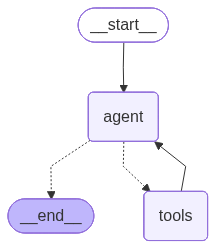

In [4]:
from datetime import datetime

from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent

from deep_agents_from_scratch.prompts import SUBAGENT_USAGE_INSTRUCTIONS
from deep_agents_from_scratch.state import DeepAgentState
from deep_agents_from_scratch.task_tool import _create_task_tool

# Limits
max_concurrent_research_units = 3
max_researcher_iterations = 3

# Mock search result
search_result = """모델 컨텍스트 프로토콜(MCP)은 Anthropic이 개발한 개방형 표준 프로토콜로, 
AI 모델과 도구, 데이터베이스, 기타 서비스와 같은 외부 시스템 간의 원활한 통합을 가능하게 합니다. 
이는 표준화된 통신 계층 역할을 하여 AI 모델이 다양한 출처의 데이터에 일관되고 효율적인 방식으로 접근하고 활용할 수 있도록 합니다.
본질적으로 MCP는 데이터 교환을 위한 통합 언어를 제공함으로써AI 어시스턴트를 외부 서비스에 연결하는 과정을 단순화합니다.
"""


# Mock search tool
@tool(parse_docstring=True)
def web_search(
    query: str,
):
    """특정 주제에 대한 정보를 웹에서 검색합니다.

    이 도구는 웹 검색을 수행하고 주어진 쿼리에 대한 관련 결과를 반환합니다.
    인터넷에서 어떤 주제에 대한 정보를 수집해야 할 때 사용하세요.

    Args:
        query: 검색 쿼리 문자열. 찾고자 하는 정보에 대해 구체적이고 명확하게 작성하세요.

    Returns:
        검색 엔진에서 반환된 검색 결과.

    Example:
        web_search(“의료 분야에서의 머신 러닝 응용”)
    """
    return search_result


# Add mock research instructions
SIMPLE_RESEARCH_INSTRUCTIONS = """당신은 연구원입니다. 제공된 주제를 연구하십시오. 중요: web_search 도구에 단 한 번만 호출하고, 해당 도구가 제공하는 결과를 사용하여 주어진 주제에 답하십시오."""

# Create research sub-agent
research_sub_agent = {
    "name": "research-agent",
    "description": "하위 에이전트 연구원에게 연구를 위임하십시오. 이 연구원에게는 한 번에 하나의 주제만 부여하십시오.",
    "prompt": SIMPLE_RESEARCH_INSTRUCTIONS,
    "tools": ["web_search"],
}

# Create agent using create_react_agent directly
model = init_chat_model(model="openai:gpt-5-nano", temperature=0.0)

# Tools for sub-agent
sub_agent_tools = [web_search]

# Create task tool to delegate tasks to sub-agents
task_tool = _create_task_tool(
    sub_agent_tools, [research_sub_agent], model, DeepAgentState
)

# Tools
delegation_tools = [task_tool]

# Create agent with system prompt
agent = create_react_agent(
    model,
    delegation_tools,
    prompt=SUBAGENT_USAGE_INSTRUCTIONS.format(
        max_concurrent_research_units=max_concurrent_research_units,
        max_researcher_iterations=max_researcher_iterations,
        date=datetime.now().strftime("%a %b %#d, %Y"),
    ),
    state_schema=DeepAgentState,
)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [5]:
from notebooks.utils import format_messages

result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "모델 컨텍스트 프로토콜(MCP)에 대한 개요를 설명해 주세요.",
            }
        ],
    }
)

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ 모델 컨텍스트 프로토콜(MCP)에 대한 개요를 설명해 주세요.                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 다음은 모델 컨텍스트 프로토콜(MCP)에 대한 개요입니다. 이 내용은 MCP가 일반적으로 지향하는 개념적 프레임워크를   │
│ 바탕으로 정리한 것이며, 구체적인 구현은 표준화된 정의에 따라 다를 수 있습니다. 필요하면 특정 도메인이나 표준    │
│ 문서를 근거로 세부 내용을 맞춤형으로 정리해 드리겠습니다.                                                       │
│                                                                                                                 │
│ 1) 정의                                                                                                         │
│ - MCP는 모델과 외부 시스템 간에 맥락(context) 정보를 표준화된 방식으로 교환하기 위한 프로토콜입니다.            │
│ - 목적은 모델이 수행하는 작업의 의도, 제약, 데이터 형식, 보안 요구사항 등을 명확히 전달하고, 상호 운용성과      │
│ 재현성을 높이는 데 있습니다.                                                                                    │
│                                                                                                                 │
│ 2) 핵심 구성 요소                                                                                               │
│ - 맥락 설명(Context Descriptor): 주제, 도메인, 목표, 제약사항(시간, 자원, 품질 기준 등), 사용자의 역할과 권한   │
│ 정보를 포함합니다.                                                                                              │
│ - 데이터 의미론(Data Semantics): 입력 데이터의 형식, 데이터 품질 메타데이터, 용어 사전, 용어 정의를             │
│ 표준화합니다.                                                                                                   │
│ - 세션 시맨틱(Session Semantics): 대화 흐름, 현재 상태, 기대되는 대화 결과, 컨텍스트의 유효 기간 등을           │
│ 정의합니다.                                                                                                     │
│ - 기능 신호(Capability Signals): 모델의 버전, 사용 가능한 기능, 제한사항(안전성, 프라이버시, 출력 형식 등)을    │
│ 명시합니다.                                                                                                     │
│ - 평가 및 출처(Evaluation & Provenance): 평가 기준, 실험 기록, 버전 관리 체계, 데이터 출처의 추적 가능성 등을   │
│ 포함합니다.                                                                                                     │
│ - 준수 및 안전(Compliance & Safety): 개인정보 처리, 민감 데이터 취급 정책, 보안 요구사항 등을 명시합니다.       │
│ - 확장성(Extensibility): 향후 모듈, 플러그인, 확장 포인트를 미리 정의합니다.                                    │
│ - 상호 운용 계층(Interoperability Layer): API 계약, 메시지 포맷(예: JSON 기반 구조, 표준 컨트랙트 등), 에러     │
│ 핸들링 규칙을 포함합니다.                                                                                       │
│                                                                                                                 │
│ 3) 작동 원리                                                                                                    │
│ - 초기 핸드쉐이크: 요청자와 모델 사이에 맥락 스펙이 교환되며, 서로의 역할과 기대를 확인합니다.                  │
│ - 맥락 협상(Context Negotiation): 작업 시작 전 맥락의 불일치를 해소하고 필요 시 업데이트합니다.                 │
│ - 맥락 생애주기(Context Lifecycle): 생성 -> 갱신(또는 확장) -> 종료의 순환으로 관리되며, 각 단계에서 버전       │
│ 관리가 이뤄집니다.                                                                                              │
│ - 검증 및 감사(Validation & Audit): 교환된 맥락이 유효하고 안전한지 검증하고, 필요 시 감사 기록을 남깁니다.     │
│                                                                                                                 │
│ 4) 일반 사용 사례                                                                                               │
│ - 다기관 협업에서 각 참여 시스템의 맥락 요구사항을 일관되게 전달                                                │
│ - 대규모 언어 모델 조정 시 정책, 도메인 지식, 데이터 형식의 일관성 확보                                         │
│ - 프라이버시 보호가 필요한 데이터 처리 시 맥락 수준에서의 접근 제어 및 데이터 최소화 구현                       │
│ - 규정 준수 환경에서 모델 결정 과정을 투명하게 기록 및 재현 가능하도록 하는 경우                                │
│                                                                                                                 │
│ 5) 기대 이점                                                                                                    │
│ - 명확성 증가: 맥락 정보가 표준화되어 혼동 가능성이 줄어듭니다.                                                 │
│ - 재현성 강화: 동일 맥락으로 동일 결과를 재현하기 쉬워집니다.                   

Trace: 
https://smith.langchain.com/public/26cc1c2b-e785-4c6d-a2a7-c30a31875fc7/r
<!-- https://smith.langchain.com/public/edc4e672-db9c-457a-953d-f62e7813591c/r -->